# US Total Person Income Analysis
## Part 2: Income range Modeling

## Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import ast
import sys

In [23]:
# import usefull functions from utils.py
sys.path.append(path.join("scripts"))

from utils import (
    import_data,
    data_preparation,
    get_pipeline,
    manual_weighted_f1_score_gridsearch,
)
from plot_utils import plot_confusion_matrix


In [16]:
# sklearn imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    PrecisionRecallDisplay,
)
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from dython.nominal import associations


In [4]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.1.


## Import data

In [5]:
# column information
file = open(path.join("data", "infos_columns.json"), "r")
contents = file.read()
dict_infos_columns = ast.literal_eval(contents)

In [6]:
# train and test sets
data_train = import_data(
    path.join("data", "census_income_learn.csv"), dict_infos_columns
)
data_test = import_data(path.join("data", "census_income_test.csv"), dict_infos_columns)


## Preprocessing
- Data preparation:

The analysis focuses on individuals >= 16 years old.

The migration columns are ignored as they have many np.nan.

The year column is dropped.

The wage_per_your column is ignored as it seems not very consistent and with a large majority of np.nan.
- Map values of the target
- Split data into X_train, X_test, y_train, y_test

In [7]:
# data preparation
data_train = data_preparation(data_train)
data_test = data_preparation(data_test)

In [8]:
# map values of income_range
mapping_income_dict = dict(
    zip(data_train["income_range"].value_counts().index.tolist(), [0, 1])
)
print(mapping_income_dict)
data_train["income_range"] = data_train["income_range"].map(mapping_income_dict)
data_test["income_range"] = data_test["income_range"].map(mapping_income_dict)


{' - 50000.': 0, ' 50000+.': 1}


In [9]:
# split data into X_train, y_train, X_test, y_test 
X_train = data_train.drop(['income_range', 'instance_weight'], axis=1)
y_train = data_train['income_range']

X_test = data_test.drop(['income_range', 'instance_weight'], axis=1)
y_test = data_test['income_range']

## Feature engineering
- Arbitrarily remove correlated variables using the association function of the dython package to quantify association between features (categorical as well as quantitative):
http://shakedzy.xyz/dython/
- Define a preprocessor using sklearn.compose.ColumnTransformer

In [10]:
train_sample_weights = data_train['instance_weight'].values
test_sample_weights = data_test['instance_weight'].values

### Features arbitrary dropped because very correlated with at least one other variable

#### Association matrix before dropping

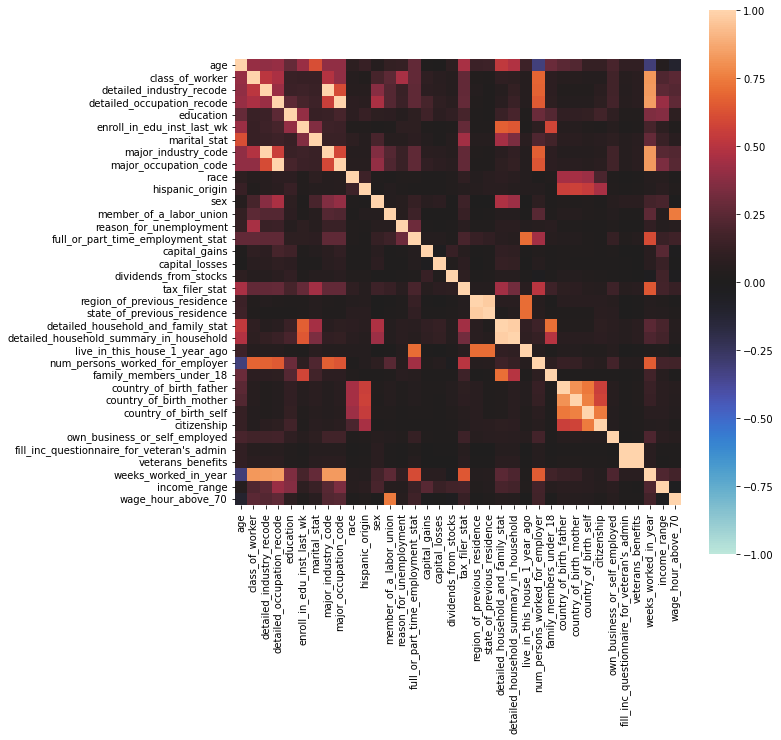

In [12]:
fig_features_associations_initial = associations(
    data_train.drop(["instance_weight"], axis=1),
    figsize=(10, 10),
    annot=False,
)

#### Drop correlated features

In [11]:
to_drop_class_of_worker = [
    "detailed_industry_recode",
    "detailed_occupation_recode",
    "major_occupation_code",
    "major_industry_code",
]
to_drop_origin = [col for col in X_train.columns if "country" in col] + [
    "hispanic_origin"
]
drop_previous_residence = ["state_of_previous_residence"]
to_drop_household_detail = ["detailed_household_and_family_stat"]
to_drop_veteran = ["fill_inc_questionnaire_for_veteran's_admin"]
to_drop = (
    to_drop_class_of_worker
    + to_drop_origin
    + drop_previous_residence
    + to_drop_household_detail
    + to_drop_veteran
)


In [12]:
X_train = X_train.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

#### Post-dropping association matrix

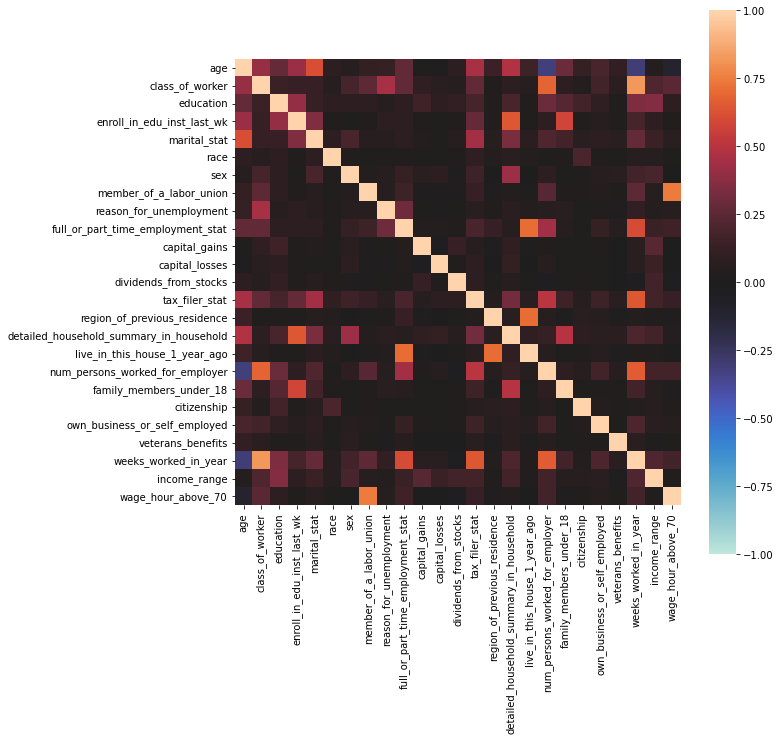

In [ ]:
fig_features_associations = associations(data_train.drop(['instance_weight']+to_drop, axis=1), figsize=(10, 10), annot=False)

#### Column Transformer Definition

In [13]:
quantitative_var = ['age', 'capital_gains', 'capital_losses', 'dividends_from_stocks', \
    'weeks_worked_in_year', 'num_persons_worked_for_employer']
categorical_var = [col for col in X_train.columns if col not in quantitative_var]

In [14]:
# Identify columns to transform
# Transformer of quantitative columns defined with a sklearn Pipeline
categorical_steps = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", missing_values=np.nan)),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    [
        (
            "quantitative",
            StandardScaler(),
            quantitative_var,
        ),
        (
            "categorical",
            categorical_steps,
            categorical_var,
        ),
    ]
)

## Classification Model for Income Range Prediction
### Model Benchmark 
- Penalized logistic regression
- Random Forest Classifier 
- Random Forest Classifier with SMOTE synthetic sampling to deal with the imbalanced repartition 
- XGBoost Classifier

Class 0: income < 50k/year 

Class 1: income > 50k/year

In [15]:
print("Target class repartition : \n", np.round((y_test.value_counts()/len(y_test)), 3))

Target class repartition : 
 0    0.917
1    0.083
Name: income_range, dtype: float64


### 1. Penalized Logistic Regression

#### Grid search with sample weights using the F1_score as the problem is imbalanced

In [ ]:
# Manual Grid Search to take into account the sample weights in the scoring as well as the training
combinations_parameters_reg_log = {
    "solver": ["liblinear", "saga"],
    "penalty": ["l1", "l2"],
    "C": [1, 10 ** (-2), 10 ** (-4), 10 ** (-6)],
}

tmp_model_param_reg_log = {"class_weight": "balanced", "max_iter": 200}

scores_reg_log = manual_weighted_f1_score_gridsearch(
    preprocessor,
    "LR",
    tmp_model_param_reg_log,
    combinations_parameters_reg_log,
    X_train,
    y_train,
    X_test,
    y_test,
    train_sample_weights,
    test_sample_weights,
)

#### Train and test best model

In [ ]:
# Best model's pipeline
# pipeline definition
solver_reg_log, penalty_reg_log, C_reg_log = max(scores_reg_log, key=scores_reg_log.get)
reg_log_param = {
        "class_weight": "balanced",
        "max_iter": 200,
        "solver": solver_reg_log,
        "penalty": penalty_reg_log,
        "C": C_reg_log,
    }
imb_reg_log = get_pipeline(preprocessor=preprocessor, estimator='LR', estimator_parameters=reg_log_param)
imb_reg_log.fit(
    X_train, y_train, classifier__sample_weight=train_sample_weights
)

#### Coefficients analysis

In [ ]:
features_post_preprocessor_names = quantitative_var + imb_reg_log.named_steps['feature_eng'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_var).tolist()

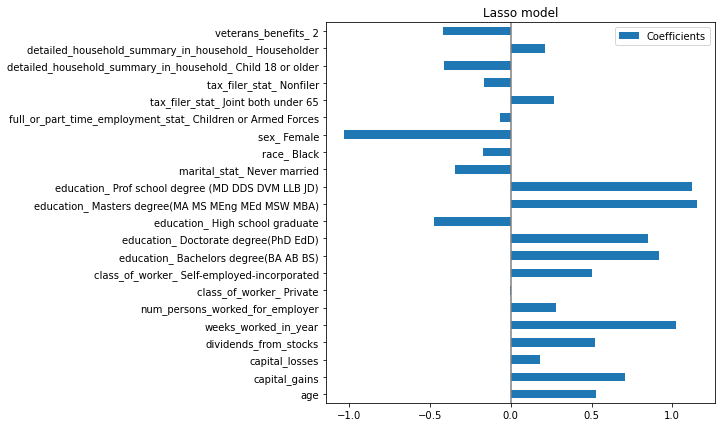

In [18]:
# The penalization reduces the influence of the correlation
coefs = pd.DataFrame(
    np.transpose(imb_reg_log.named_steps["classifier"].coef_),
    columns=["Coefficients"],
    index=features_post_preprocessor_names,
)
# plot
coefs[coefs['Coefficients']!=0].plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

#### Interpretability
The influence of the variables seems consistent.

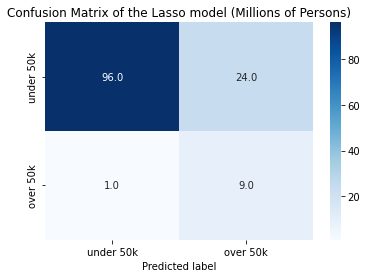

In [19]:
## Scoring using test sample weights
# predict
y_predict_reg_log = imb_reg_log.predict(X_test)
# plot confusion matrix
fig_cm_reg_log = plot_confusion_matrix(y_test, y_predict_reg_log, test_sample_weights, 'Lasso')

In [20]:
## Scoring using test sample weights
# predict
y_predict_reg_log = imb_reg_log.predict(X_test)
# classification report
print(classification_report(y_test, y_predict_reg_log, sample_weight=test_sample_weights))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88 121054163.69000088
           1       0.28      0.86      0.42 11001524.06000003

    accuracy                           0.80 132055687.75000091
   macro avg       0.63      0.83      0.65 132055687.75000091
weighted avg       0.93      0.80      0.84 132055687.75000091



#### Results
The precision of the class 1 (= income range > 50k/year) is quite unsatisfaying : only one out of 3 individual for who the model predicts a > 50k/year income is accurate.
The recall is however good. The precision recall curve of this model is represented in the last section to be compared with the others.

The advantage of this model is however its interpretability as one can analyse its non-zero coefficients.

### Model 2 : RFC

#### Grid search with sample weights

In [ ]:
combinations_parameters_rfc = {'criterion':['gini', 'entropy'], 
"max_depth":[10, 50, 100],
 "n_estimators":[10, 50, 100],
 "min_samples_leaf":[20, 30, 40]}

tmp_model_param_rfc = {"class_weight": "balanced"}

scores_rfc = manual_weighted_f1_score_gridsearch(
    preprocessor,
    "RFC",
    tmp_model_param_rfc,
    combinations_parameters_rfc,
    X_train,
    y_train,
    X_test,
    y_test,
    train_sample_weights,
    test_sample_weights,
)

In [ ]:
# # Best model's pipeline
# # pipeline definition
# criterion_rfc, max_depth_rfc, n_rfc, min_samples_leaf = max(scores_rfc, key=scores_rfc.get)
# rfc_param = {
#         "class_weight": "balanced",
#         "criterion":criterion_rfc,
#         "max_depth": max_depth_rfc,
#         "n_estimators":n_rfc,
#         "min_samples_leaf":min_samples_leaf
#     }
# imb_rfc = get_pipeline(preprocessor=preprocessor, estimator='RFC', estimator_parameters=rfc_param)
# imb_rfc.fit(
#     X_train, y_train, classifier__sample_weight=train_sample_weights
# )

In [51]:
# Best model's pipeline
# pipeline definition
rfc_param = {
        "class_weight": "balanced",
        "criterion":"gini",
        "max_depth": 50,
        "n_estimators":50,
        "min_samples_leaf":20
    }
imb_rfc = get_pipeline(preprocessor=preprocessor, estimator='RFC', estimator_parameters=rfc_param)
imb_rfc.fit(
    X_train, y_train, classifier__sample_weight=train_sample_weights
)

Pipeline(steps=[('feature_eng',
                 ColumnTransformer(transformers=[('quantitative',
                                                  StandardScaler(),
                                                  ['age', 'capital_gains',
                                                   'capital_losses',
                                                   'dividends_from_stocks',
                                                   'weeks_worked_in_year',
                                                   'num_persons_worked_for_employer']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                 

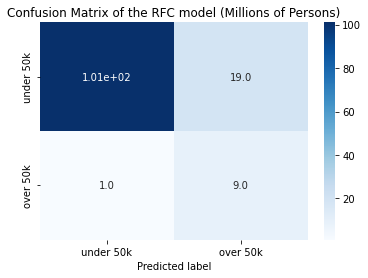

In [26]:
## Scoring using test sample weights
# predict
y_predict_rfc = imb_rfc.predict(X_test)
# plot confusion matrix
fig_cm_rfc = plot_confusion_matrix(y_test, y_predict_rfc, test_sample_weights, 'RFC')

In [27]:
## Scoring using test sample weights
# predict
y_predict_reg_log = imb_rfc.predict(X_test)
# classification report
print(classification_report(y_test, y_predict_reg_log, sample_weight=test_sample_weights))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91 121054163.69000088
           1       0.33      0.85      0.47 11001524.06000003

    accuracy                           0.84 132055687.75000091
   macro avg       0.66      0.85      0.69 132055687.75000091
weighted avg       0.93      0.84      0.87 132055687.75000091



In [ ]:
# features names after onehot encoding
features_post_preprocessor_names = quantitative_var + imb_rfc.named_steps['feature_eng'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_var).tolist()

In [ ]:
### Permutation FI : more costly but better with high cardinality categorical features
result = permutation_importance(
    imb_rfc, X_test, y_test, n_repeats=5, random_state=42)
forest_importances = pd.Series(result.importances_mean, index=X_test.columns.tolist())

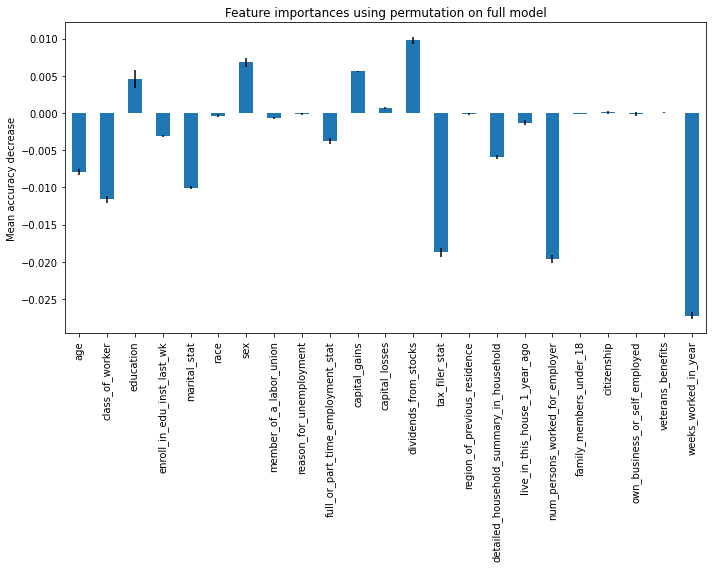

In [36]:
#plot
fig, ax = plt.subplots(figsize=(10, 8))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#### Conclusion
The performance of the Random Forest model is close to the previous one. The precision is slightly better.
The age variable appears as not very influancal on the output of the model which may not be consistent with the descriptive analysis. It may be due to the poor precision of the output but also to the remaining correlation between this variable and the others.

### Model 3 : RFC with SMOTE and SVD

In [52]:
# Define pipeline and fit
imb_rfc_smote = ImbPipeline(
        [
            ("feature_eng", preprocessor),
            ("sm", SMOTE(random_state=42)), # -> no sample weight in train but maintained in test
            ('SVD', TruncatedSVD(n_components=10)),
            ("classifier", RandomForestClassifier(random_state=42)),
        ]
)
imb_rfc_smote.fit(X_train, y_train)

Pipeline(steps=[('feature_eng',
                 ColumnTransformer(transformers=[('quantitative',
                                                  StandardScaler(),
                                                  ['age', 'capital_gains',
                                                   'capital_losses',
                                                   'dividends_from_stocks',
                                                   'weeks_worked_in_year',
                                                   'num_persons_worked_for_employer']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                 

In [ ]:
## Scoring using test sample weights
# predict
y_predict_rfc = imb_rfc_smote.predict(X_test)
# classification report
print(classification_report(y_test, y_predict_rfc, sample_weight=test_sample_weights))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96 121054163.69000088
           1       0.52      0.53      0.52 11001524.06000003

    accuracy                           0.92 132055687.75000091
   macro avg       0.74      0.74      0.74 132055687.75000091
weighted avg       0.92      0.92      0.92 132055687.75000091



#### Conclusion
The performance of the precision is better than previously but not very satisfaying yet. The recall has however decreased.

### Model 4 : Xgboost

#### Gridsearch

In [ ]:
combinations_parameters_xgb = {
'lambda':[0.1, 0.01], 
'alpha':[0.1, 0.01],
"max_depth":[5, 10, 50],
"n_estimators":[10, 50, 100]}

tmp_model_param_xgb = {"class_weight": "balanced"}

scores_xgb = manual_weighted_f1_score_gridsearch(
    preprocessor,
    "XGB",
    tmp_model_param_xgb,
    combinations_parameters_xgb,
    X_train,
    y_train,
    X_test,
    y_test,
    train_sample_weights,
    test_sample_weights,
)

#### Best model

In [ ]:
# Best model's pipeline
# pipeline definition
#lambda_xgb, alpha_xgb, max_depth_xgb, n_estimators_xgb = max(scores_xgb, key=scores_xgb.get)
lambda_xgb, alpha_xgb, max_depth_xgb, n_estimators_xgb = (0.01, 0.01, 10, 50)
xgb_param = {
        "class_weight": "balanced",
        "lambda": lambda_xgb,
        "alpha": lambda_xgb,
        "max_depth": max_depth_xgb,
        "n_estimators": n_estimators_xgb,
    }

imb_xgb = get_pipeline(preprocessor=preprocessor, estimator='XGB', estimator_parameters=xgb_param)
imb_xgb.fit(
    X_train, y_train, classifier__sample_weight=train_sample_weights
)

In [46]:
## Scoring using test sample weights
# predict
y_predict_rfc = imb_xgb.predict(X_test)
# classification report
print(classification_report(y_test, y_predict_rfc, sample_weight=test_sample_weights))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97 121054163.69000088
           1       0.67      0.46      0.55 11001524.06000003

    accuracy                           0.94 132055687.75000091
   macro avg       0.81      0.72      0.76 132055687.75000091
weighted avg       0.93      0.94      0.93 132055687.75000091



#### Conclusion
The precision has increased compared to all the other models. However the recall is lower than the Logistic Regression.

## Precision-Recall Curves Comparison

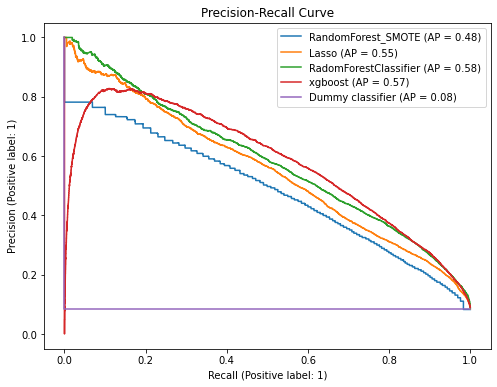

In [53]:
# Define Dummy classifier to compare
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)

# models
models = {"RandomForest_SMOTE":imb_rfc_smote,
"Lasso":imb_reg_log,
"RadomForestClassifier":imb_rfc,
"xgboost":imb_xgb,
"Dummy classifier":dummy_clf}

# Plot Precision-Recall Curves
fig, ax = plt.subplots(figsize=(8, 6))
for model_name in models.keys():
    PrecisionRecallDisplay.from_estimator(
        models[model_name], X_test, y_test, name=model_name, ax=ax)
ax.set_title('Precision-Recall Curve')
plt.legend(loc=1)

### Conclusion

The best trade-off between precision and recall may correspond to the xgboost model.